<a href="https://colab.research.google.com/github/Magferat/Clustering-with-Neural-Networks/blob/main/DEC%20with%20KMEANS_CSE425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tqdm scikit-learn matplotlib torchvision datasets


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 28x28
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon


In [ ]:
ae = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

# Pretrain loop
for epoch in range(20):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"AE Epoch {epoch+1}"):
        imgs = imgs.to(device)
        _, recons = ae(imgs)
        loss = criterion(recons, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


AE Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2026


AE Epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2, Loss: 0.1008


AE Epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0863


AE Epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0790


AE Epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0744


AE Epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0711


AE Epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0685


AE Epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0665


AE Epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0647


AE Epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0632


AE Epoch 11:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11, Loss: 0.0620


AE Epoch 12:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12, Loss: 0.0609


AE Epoch 13:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13, Loss: 0.0599


AE Epoch 14:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14, Loss: 0.0592


AE Epoch 15:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15, Loss: 0.0585


AE Epoch 16:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16, Loss: 0.0579


AE Epoch 17:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17, Loss: 0.0573


AE Epoch 18:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18, Loss: 0.0569


AE Epoch 19:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19, Loss: 0.0564


AE Epoch 20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20, Loss: 0.0559


In [ ]:
def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

class DEC:
    def __init__(self, model, n_clusters=10, alpha=1.0):
        self.model = model
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(
            torch.randn(n_clusters, 10, dtype=torch.float32).to(device)
        )

    def soft_assign(self, z):
        z = z.float()
        dist = torch.cdist(z, self.cluster_centers, p=2) ** 2
        num = (1.0 + dist / self.alpha) ** ((self.alpha + 1.0) / -2)
        return (num.T / num.sum(1)).T  # shape: (batch, n_clusters)

    def kl_loss(self, q, p):
        return torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')

# Step 1: Extract embeddings
ae.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        all_embeddings.append(z.cpu())
        all_labels.append(labels)

embeddings = torch.cat(all_embeddings)
labels = torch.cat(all_labels)

# Step 2: Init cluster centers with KMeans
kmeans = KMeans(n_clusters=10, n_init=20)
y_pred = kmeans.fit_predict(embeddings)
dec = DEC(ae, 10)
dec.cluster_centers.data = torch.tensor(
    kmeans.cluster_centers_, dtype=torch.float32, device=device
)

# Step 3: DEC training
optimizer = optim.Adam(
    [{'params': ae.encoder.parameters()}, {'params': dec.cluster_centers}], lr=1e-3
)

for epoch in range(20):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"DEC Epoch {epoch+1}"):
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        q = dec.soft_assign(z)
        p = target_distribution(q.detach())
        loss = dec.kl_loss(q, p)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[DEC] Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


DEC Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 1, Loss: 0.2185


DEC Epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 2, Loss: 0.1900


DEC Epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 3, Loss: 0.1760


DEC Epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 4, Loss: 0.1673


DEC Epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 5, Loss: 0.1610


DEC Epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 6, Loss: 0.1567


DEC Epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 7, Loss: 0.1517


DEC Epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 8, Loss: 0.1484


DEC Epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 9, Loss: 0.1449


DEC Epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 10, Loss: 0.1424


DEC Epoch 11:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 11, Loss: 0.1394


DEC Epoch 12:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 12, Loss: 0.1373


DEC Epoch 13:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 13, Loss: 0.1347


DEC Epoch 14:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 14, Loss: 0.1325


DEC Epoch 15:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 15, Loss: 0.1310


DEC Epoch 16:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 16, Loss: 0.1288


DEC Epoch 17:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 17, Loss: 0.1273


DEC Epoch 18:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 18, Loss: 0.1255


DEC Epoch 19:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 19, Loss: 0.1242


DEC Epoch 20:   0%|          | 0/235 [00:00<?, ?it/s]

[DEC] Epoch 20, Loss: 0.1225


In [ ]:

ae.eval()
with torch.no_grad():
    all_z = []
    for imgs, _ in train_loader:
        z, _ = ae(imgs.to(device))
        all_z.append(z.cpu())
    z = torch.cat(all_z).numpy()

# KMeans clustering
kmeans = KMeans(n_clusters=10, n_init=20).fit(z)
labels_pred = kmeans.labels_

# Evaluation metrics
sil = silhouette_score(z, labels_pred)
db = davies_bouldin_score(z, labels_pred)
chi = calinski_harabasz_score(z, labels_pred)

print(f"Silhouette Score:         {sil:.4f}")
print(f"Davies-Bouldin Index:     {db:.4f}")
print(f"Calinski-Harabasz Index:  {chi:.4f}")


Silhouette Score:         0.7178
Davies-Bouldin Index:     0.3799
Calinski-Harabasz Index:  136881.2031


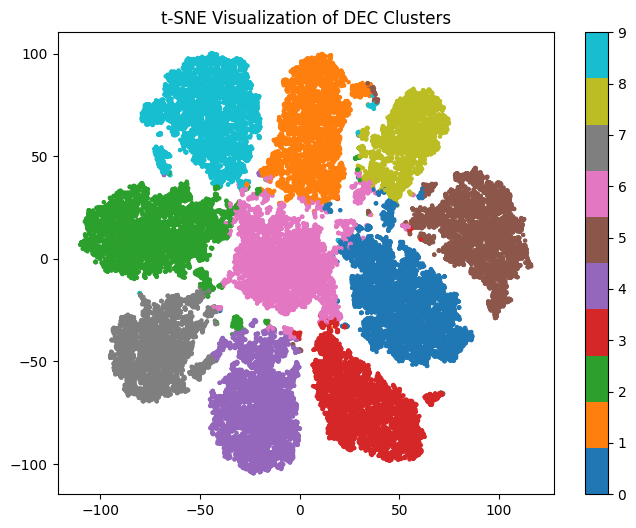

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=kmeans.labels_, cmap='tab10', s=5)
plt.title("t-SNE Visualization of DEC Clusters")
plt.colorbar()
plt.show()


In [ ]:
import pickle

with open("dec_results.pkl", "wb") as f:
    pickle.dump({
        "embeddings": z,
        "labels": labels.numpy(),
        "preds": kmeans.labels_,
        "silhouette": sil,
        "db_score": db
    }, f)
torch.save(ae.state_dict(), "autoencoder_mnist.pth")
